In [1]:
from data_loader import read_json_as_df

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

pd.options.display.max_colwidth = 200 

In [2]:
train_df = read_json_as_df('Data/clpsych16-train.json')
test_df = read_json_as_df('Data/clpsych16-test.json')

Mean: 411.0960929250264 
Median: 218.0 
Std: 600.4321149494463 


{'whiskers': [<matplotlib.lines.Line2D at 0x14347eddf28>,
 'caps': [<matplotlib.lines.Line2D at 0x14347ef1630>,
 'boxes': [<matplotlib.lines.Line2D at 0x14347edddd8>],
 'medians': [<matplotlib.lines.Line2D at 0x14347ef1d68>],
 'fliers': [<matplotlib.lines.Line2D at 0x14347f00128>],
 'means': []}

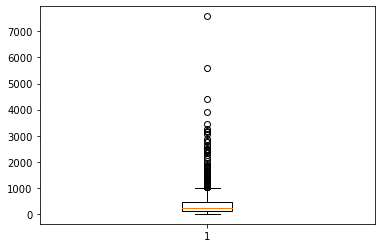

In [3]:
text_lengths = np.array([len(sent) for sent in train_df.text])

print(f'Mean: {np.mean(text_lengths)} \nMedian: {np.median(text_lengths)} \nStd: {np.std(text_lengths)} ')

plt.boxplot(text_lengths)

Mean: 402.1701244813278 
Median: 251.0 
Std: 516.6792066581842 


{'whiskers': [<matplotlib.lines.Line2D at 0x14347f9a908>,
 'caps': [<matplotlib.lines.Line2D at 0x14347f9afd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14347f9a7b8>],
 'medians': [<matplotlib.lines.Line2D at 0x14347fa5710>],
 'fliers': [<matplotlib.lines.Line2D at 0x14347fa5a90>],
 'means': []}

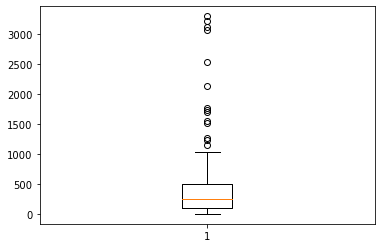

In [4]:
text_lengths = np.array([len(sent) for sent in test_df.text])

print(f'Mean: {np.mean(text_lengths)} \nMedian: {np.median(text_lengths)} \nStd: {np.std(text_lengths)} ')

plt.boxplot(text_lengths)

In [5]:
train_df.priority.value_counts()

green       549
amber       249
red         110
escalate     39
Name: priority, dtype: int64

In [6]:
test_df.priority.value_counts()

green       166
amber        47
red          27
escalate      1
Name: priority, dtype: int64

In [7]:
vectorizer = TfidfVectorizer()

# Initial model creation without using test set

In [8]:
features = vectorizer.fit_transform(train_df.text)

In [9]:
features.shape

(947, 5379)

In [10]:
%%time
# X_train, X_test, y_train, y_test = train_test_split(features, 
#                                                     train_df.priority,
#                                                     test_size=0.3,
#                                                     # random_state=4,
#                                                     stratify=train_df.priority)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)


params = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1), 'kernel': ['rbf'], 'class_weight':['balanced']}

clf = RandomizedSearchCV(estimator=SVC(),
                         param_distributions=params,
                         n_jobs=-1,
                         scoring='f1_macro',
                         cv=5,
                         n_iter=100)

searched_clf = clf.fit(features, train_df.priority)

print(searched_clf.best_params_)
print(searched_clf.best_score_)
print(searched_clf.best_estimator_)



{'C': 9.758524030644347, 'class_weight': 'balanced', 'gamma': 0.026788062720575264, 'kernel': 'rbf'}
0.5097350773968585
SVC(C=9.758524030644347, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.026788062720575264, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
Wall time: 25.3 s


# Main method to train and test classifier

In [11]:
def run_tfidf_svc(clf, xtrain, ytrain, xtest, ytest):
    
    vectorizer = TfidfVectorizer()
    
    train_features = vectorizer.fit_transform(xtrain)
    test_features = vectorizer.transform(xtest)
    
    print(f'Training feature size: {train_features.shape} \nTesting feature size: {test_features.shape}\n')
    
    print(clf, '\n')
    
    clf.fit(train_features, ytrain)
    
    predicted_priority = clf.predict(test_features)

    print('Classification Report:\n', classification_report(ytest, predicted_priority))
    
    

# Train and test on full datasets

## Official - ignoring 'green' priority

In [12]:

official_train_df = train_df[train_df.priority != 'green']
official_test_df = test_df[test_df.priority != 'green']

run_tfidf_svc(clf = searched_clf.best_estimator_,
              xtrain = official_train_df.text,
              ytrain = official_train_df.priority,
              xtest = official_test_df.text,
              ytest = official_test_df.priority)


Training feature size: (398, 3698) 
Testing feature size: (75, 3698)

SVC(C=9.758524030644347, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.026788062720575264, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False) 

Classification Report:
               precision    recall  f1-score   support

       amber       0.81      0.74      0.78        47
    escalate       0.00      0.00      0.00         1
         red       0.62      0.67      0.64        27

    accuracy                           0.71        75
   macro avg       0.48      0.47      0.47        75
weighted avg       0.73      0.71      0.72        75



## Flagged - 'crisis + red + amber' as flagged vs 'green'

In [13]:
flagged_train_df = train_df.copy()
flagged_test_df = test_df.copy()

flagged_train_df.priority = flagged_train_df.priority.replace(to_replace=['red', 'escalate', 'amber'], value='flagged')
flagged_test_df.priority = flagged_test_df.priority.replace(to_replace=['red', 'escalate', 'amber'], value='flagged')

print(flagged_train_df.priority.value_counts(), '\n')
print(flagged_test_df.priority.value_counts(), '\n')

run_tfidf_svc(clf = searched_clf.best_estimator_,
              xtrain = flagged_train_df.text,
              ytrain = flagged_train_df.priority,
              xtest = flagged_test_df.text,
              ytest = flagged_test_df.priority)



green      549
flagged    398
Name: priority, dtype: int64 

green      166
flagged     75
Name: priority, dtype: int64 

Training feature size: (947, 5379) 
Testing feature size: (241, 5379)

SVC(C=9.758524030644347, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.026788062720575264, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False) 

Classification Report:
               precision    recall  f1-score   support

     flagged       0.74      0.89      0.81        75
       green       0.95      0.86      0.90       166

    accuracy                           0.87       241
   macro avg       0.85      0.88      0.86       241
weighted avg       0.88      0.87      0.87       241



## Urgent - 'red + escalate' as urgent vs 'amber + green' as non_urgent

In [14]:
urgent_train_df = train_df.copy()
urgent_test_df = test_df.copy()

urgent_train_df.priority = urgent_train_df.priority.replace(to_replace=['red', 'escalate'], value='urgent')
urgent_train_df.priority = urgent_train_df.priority.replace(to_replace=['green', 'amber'], value='non_urgent')

urgent_test_df.priority = urgent_test_df.priority.replace(to_replace=['red', 'escalate'], value='urgent')
urgent_test_df.priority = urgent_test_df.priority.replace(to_replace=['green', 'amber'], value='non_urgent')

print(urgent_train_df.priority.value_counts(), '\n')
print(urgent_test_df.priority.value_counts(), '\n')

run_tfidf_svc(clf = searched_clf.best_estimator_,
              xtrain = urgent_train_df.text,
              ytrain = urgent_train_df.priority,
              xtest = urgent_test_df.text,
              ytest = urgent_test_df.priority)


non_urgent    798
urgent        149
Name: priority, dtype: int64 

non_urgent    213
urgent         28
Name: priority, dtype: int64 

Training feature size: (947, 5379) 
Testing feature size: (241, 5379)

SVC(C=9.758524030644347, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.026788062720575264, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False) 

Classification Report:
               precision    recall  f1-score   support

  non_urgent       0.97      0.90      0.93       213
      urgent       0.51      0.82      0.63        28

    accuracy                           0.89       241
   macro avg       0.74      0.86      0.78       241
weighted avg       0.92      0.89      0.90       241



## Full dataset with individual categories

In [ ]:
run_tfidf_svc(clf = searched_clf.best_estimator_,
              xtrain = train_df.text,
              ytrain = train_df.priority,
              xtest = test_df.text,
              ytest = test_df.priority)

In [15]:
# Temp Rough Work

Training feature size: (947, 5379) 
Testing feature size: (241, 5379)

SVC(C=9.758524030644347, break_ties=False, cache_size=200,
    class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.026788062720575264, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False) 

Classification Report:
               precision    recall  f1-score   support

       amber       0.52      0.66      0.58        47
    escalate       0.00      0.00      0.00         1
       green       0.95      0.85      0.90       166
         red       0.55      0.63      0.59        27

    accuracy                           0.78       241
   macro avg       0.50      0.53      0.52       241
weighted avg       0.82      0.78      0.80       241



# Temp Rough Work

In [16]:
# train_features = vectorizer.fit_transform(train_df.text)

# test_features = vectorizer.transform(test_df[test_df.priority != 'green'].text)

# print(train_features.shape, train_df.priority.shape)
# print(test_features.shape, test_df[test_df.priority != 'green'].priority.shape, '\n')

# svc_clf = SVC(class_weight='balanced')

# print(svc_clf, '\n')

# svc_clf.fit(train_features, train_df.priority)

# predicted_priority = svc_clf.predict(test_features)

# print(classification_report(test_df[test_df.priority != 'green'].priority, predicted_priority))